In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib
import os

In [2]:
# Generate 400 rows of synthetic but realistic data
rng = np.random.default_rng(42)
n = 400
study_hours = np.clip(rng.normal(3.5, 1.5, n), 0, 8)       # 0–8 hrs/day
attendance = np.clip(rng.normal(85, 10, n), 50, 100)       # 50–100 %
past_score = np.clip(rng.normal(65, 15, n), 0, 100)        # 0–100

# True relationship + noise (you can tweak these weights)
final_score = (
    0.45 * past_score +
    0.35 * (study_hours * 10) +   # scale hours to ~0-80
    0.20 * attendance +
    rng.normal(0, 5, n)
)
final_score = np.clip(final_score, 0, 100)

df = pd.DataFrame({
    "study_hours": study_hours.round(2),
    "attendance": attendance.round(1),
    "past_score": past_score.round(1),
    "final_score": final_score.round(1)
})
df.head()


,study_hours,attendance,past_score,final_score
0,3.96,83.2,52.3,47.4
1,1.94,87.0,48.7,43.7
2,4.63,93.2,70.2,68.5
3,4.91,81.1,70.7,64.7
4,0.57,90.2,84.3,54.7


In [3]:
print(df.shape)
print(df.isna().sum())
display(df.describe())

# If there are missing values, simple fix:
df = df.fillna(df.median(numeric_only=True))


(400, 4)
study_hours    0
attendance     0
past_score     0
final_score    0
dtype: int64


,study_hours,attendance,past_score,final_score
count,400.000000,400.000000,400.000000,400.000000
mean,3.493150,84.219500,64.806500,57.868750
std,1.426518,9.668766,14.681619,9.615456
min,0.000000,55.400000,10.300000,32.300000
25%,2.497500,77.175000,56.000000,51.775000
50%,3.525000,84.600000,65.100000,57.800000
75%,4.395000,91.325000,74.200000,63.950000
max,7.870000,100.000000,100.000000,84.100000


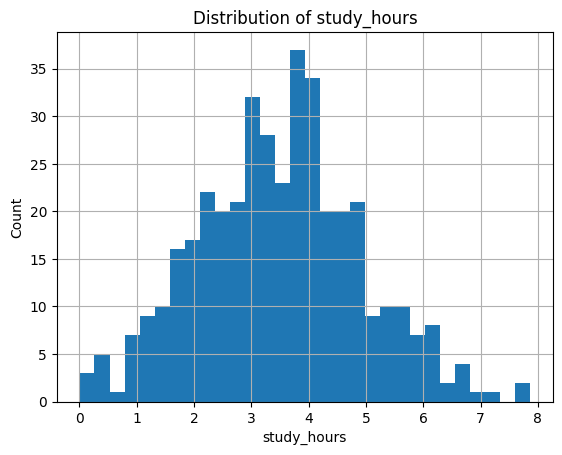

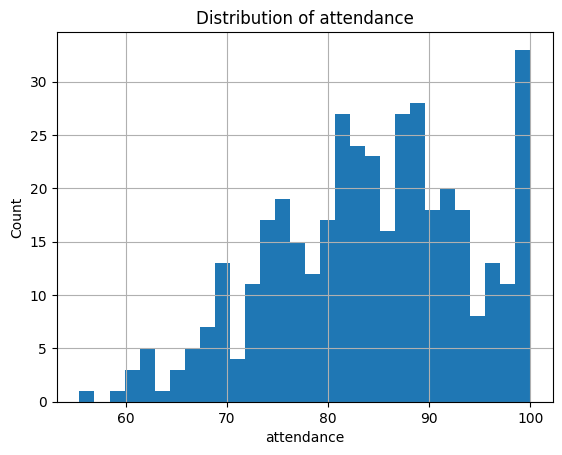

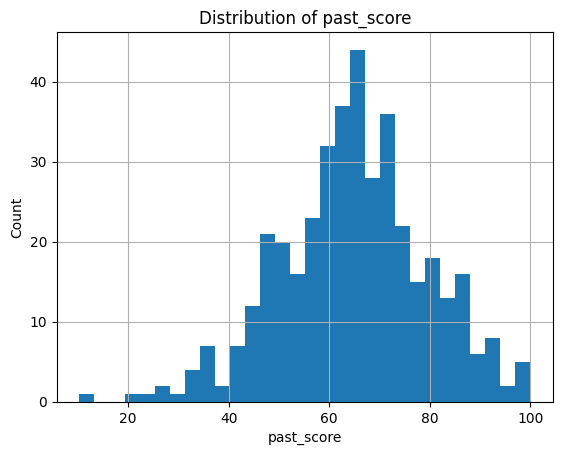

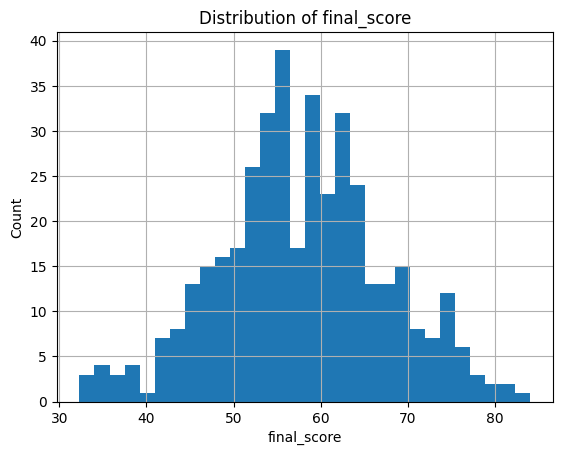

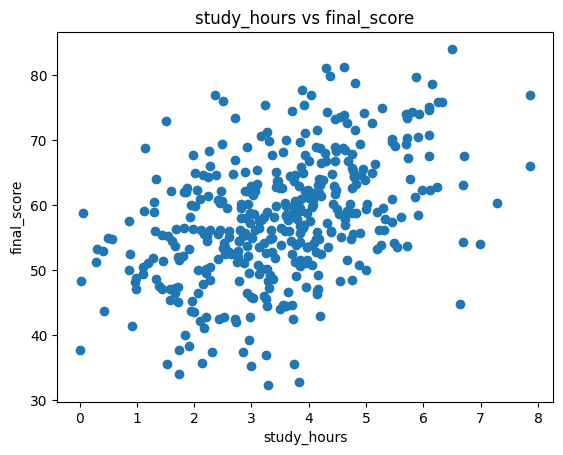

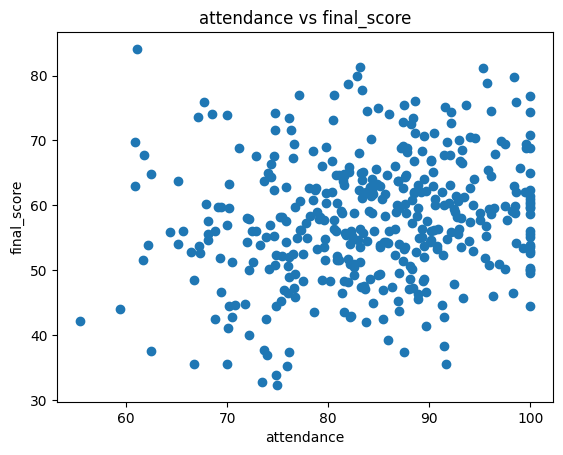

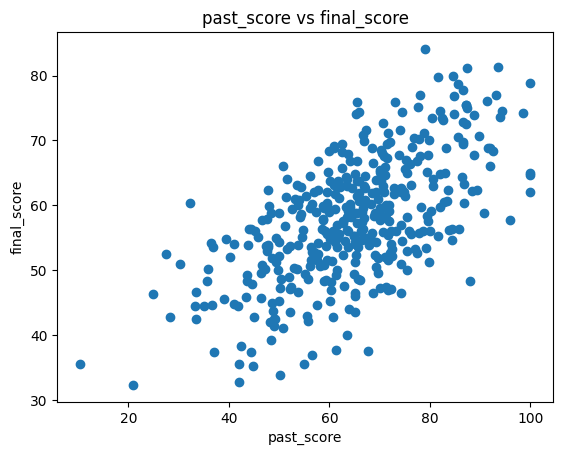

             study_hours  attendance  past_score  final_score
study_hours     1.000000   -0.035577   -0.093124     0.443153
attendance     -0.035577    1.000000   -0.042111     0.179952
past_score     -0.093124   -0.042111    1.000000     0.629317
final_score     0.443153    0.179952    0.629317     1.000000


In [4]:
# Distributions
for col in ["study_hours", "attendance", "past_score", "final_score"]:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

# Scatter relationships vs target
for col in ["study_hours", "attendance", "past_score"]:
    plt.figure()
    plt.scatter(df[col], df["final_score"])
    plt.xlabel(col)
    plt.ylabel("final_score")
    plt.title(f"{col} vs final_score")
    plt.show()

# Correlations (simple numeric)
print(df.corr(numeric_only=True))


In [5]:
X = df[["study_hours", "attendance", "past_score"]]
y = df["final_score"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape


((320, 3), (80, 3))

In [6]:
# Linear Regression (with scaling for good practice)
lin_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])
lin_pipe.fit(X_train, y_train)

# Decision Tree (no scaling needed)
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)


DecisionTreeRegressor(random_state=42)

In [12]:
def evaluate(model, X_tr, y_tr, X_te, y_te, name="model"):
    pred_tr = model.predict(X_tr)
    pred_te = model.predict(X_te)

    # Metrics (compatible with all sklearn versions)
    mae = mean_absolute_error(y_te, pred_te)
    mse = mean_squared_error(y_te, pred_te)
    rmse = mse ** 0.5
    r2 = r2_score(y_te, pred_te)

    print(f"{name} -> MAE: {mae:.2f} | RMSE: {rmse:.2f} | R2: {r2:.3f}")

    # Plot
    plt.figure()
    plt.scatter(y_te, pred_te)
    plt.xlabel("Actual Final Score")
    plt.ylabel("Predicted Final Score")
    plt.title(f"Actual vs Predicted - {name}")

    # 45-degree line
    y_true = y_te.values
    y_pred = pred_te
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]

    plt.plot(lims, lims)
    plt.show()


Best params: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Decision Tree (Tuned) -> MAE: 5.45 | RMSE: 6.51 | R2: 0.590


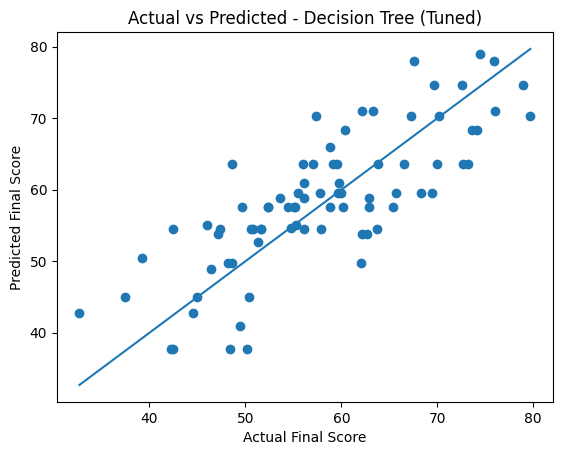

In [13]:
param_grid = {
    "max_depth": [None, 3, 5, 7, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1
)
grid.fit(X_train, y_train)
best_tree = grid.best_estimator_
print("Best params:", grid.best_params_)
evaluate(best_tree, X_train, y_train, X_test, y_test, "Decision Tree (Tuned)")

past_score     0.529077
study_hours    0.354440
attendance     0.116483
dtype: float64


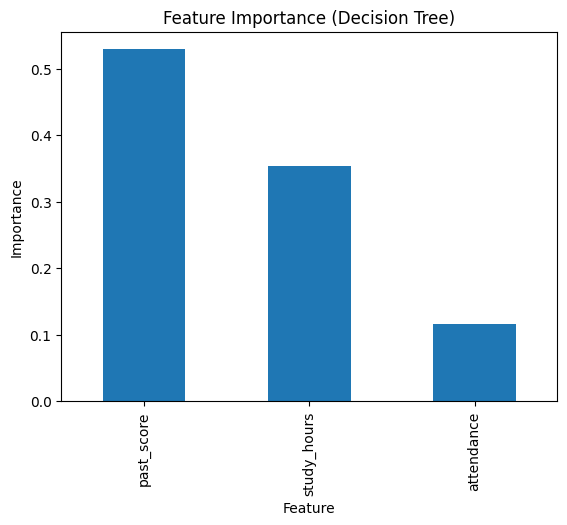

In [14]:
fi = pd.Series(best_tree.feature_importances_, index=X.columns).sort_values(ascending=False)
print(fi)

plt.figure()
fi.plot(kind="bar")
plt.title("Feature Importance (Decision Tree)")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()


In [15]:
# Compare R2/MAE from step 7/8 and choose the best
# Suppose best_tree wins (often does on non-linear relationships)
best_model = best_tree  # or lin_pipe

os.makedirs("artifacts", exist_ok=True)
joblib.dump(best_model, "artifacts/student_performance_model.joblib")
print("Saved: artifacts/student_performance_model.joblib")


Saved: artifacts/student_performance_model.joblib


In [16]:
def predict_final_score(study_hours, attendance, past_score):
    X_new = pd.DataFrame([{
        "study_hours": float(study_hours),
        "attendance": float(attendance),
        "past_score": float(past_score)
    }])
    model = joblib.load("artifacts/student_performance_model.joblib")
    return float(model.predict(X_new)[0])

# Quick test
predict_final_score(4, 90, 70)


63.53725490196079

In [19]:
from google.colab import files
files.download("artifacts/student_performance_model.joblib")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>